<a href="https://colab.research.google.com/github/adenletchworth/Player-Trend-Predictions/blob/RandomForest/Copy_of_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Average Player Count for Most Played Steam Game for a Given Month.

## Project Overview
In this project we will be taking steps to forecast average player count for a Steam game in a given month. This entails data exploration where we will familiarize ourselves with the data. Then we will perform any preprocessing steps and feature engineering. We will then build a machine learning pipeline to forecast the average player count for future months. This analysis helps us predict player movement which is a good measure of player engagement. From this measure we can make impactful decisions such as advertising more or less in a given month.

### Authors
- Aden Letchworth
- Fienna Angeline
- Gabriel Bermudez

### Dataset Overview
- **Name of the Dataset:** Popularity of Games on Steam
- **Dataset URL:** [Kaggle - Popularity of Games on Steam](https://www.kaggle.com/datasets/michau96/popularity-of-games-on-steam/data)
- **License:** CC0: Public Domain
- **Features:**
    - gamename - Name of Game
    - year - Year of Observation
    - month - Month of observation
    - avg - Average number of players concurrently
    - gain - Difference in average compared to previous month
    - peak - Peak concurrent player count
    - avg_peak_perc - Share of the average in the maximum value

## Data Exploration

In [ ]:
!pip install optuna
!pip install category_encoders

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import category_encoders as ce
import optuna
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Configurations
plt.style.use('fivethirtyeight')

In [ ]:
data_path = './Data/SteamCharts 2.csv'
df = pd.read_csv(data_path, encoding='unicode_escape') # Needs special encoding to read the file

In [ ]:
df.head()

,gamename,year,month,avg,gain,peak,avg_peak_perc
0,Counter-Strike: Global Offensive,2021,February,741013.24,-2196.42,1123485,65.9567%
1,Counter-Strike: Global Offensive,2021,January,743209.66,25405.91,1124553,66.0893%
2,Counter-Strike: Global Offensive,2020,December,717803.75,49049.17,1164396,61.646%
3,Counter-Strike: Global Offensive,2020,November,668754.58,55087.89,1037464,64.4605%
4,Counter-Strike: Global Offensive,2020,October,613666.69,6816.37,943876,65.0156%


From our head we can see we have 6 columns with a mix of categorical and numerical data.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83789 entries, 0 to 83788
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gamename       83789 non-null  object 
 1   year           83789 non-null  int64  
 2   month          83789 non-null  object 
 3   avg            83789 non-null  float64
 4   gain           82529 non-null  float64
 5   peak           83789 non-null  int64  
 6   avg_peak_perc  83789 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 4.5+ MB


We can see that we are correctly getting the right datatypes for each column except `avg_peak_perc`. This should be a float64 however, we are seeing it as an object indicating it's formatted incorrectly. From the previous head, we can see that this is due to the formatting (%).

In [ ]:
df.describe()

,year,avg,gain,peak
count,83789.000000,8.378900e+04,82529.000000,8.378900e+04
mean,2017.338708,2.792017e+03,-10.245559,5.518877e+03
std,2.237587,2.648480e+04,3789.944005,5.015571e+04
min,2012.000000,0.000000e+00,-250248.990000,0.000000e+00
25%,2016.000000,5.325000e+01,-38.310000,1.380000e+02
50%,2018.000000,2.042700e+02,-1.630000,5.020000e+02
75%,2019.000000,7.716500e+02,22.320000,1.741000e+03
max,2021.000000,1.584887e+06,426446.120000,3.236027e+06


From this description we can see that most of the columns look correct, however there are extreme values in gain. We can see that the min is -250248.990000 and the max is 82529.000000, which are likely mistakes rather than events.

In [ ]:
df.isna().sum()

gamename            0
year                0
month               0
avg                 0
gain             1260
peak                0
avg_peak_perc       0
dtype: int64

We can see that we have 1260 missing values in the gain column. We need to impute these values, luckily we can calculate these values directly with the `avg` column. However, there will be no previous avg for the start of a year, thus these values will need another form of imputation.

## Data Preprocessing and Feature Engineering

In [ ]:
df['month'][0]

'February '

From the errors thrown while trying to map Months to Nums we can see that the months are formatted incorrectly, with a trailing whitespace. We need to keep this in mind while converting them.

### Datetime Preprocessing and Feature Engineering
- Map the categorical month name to corresponding month number
- Create new `date` column by combining year and month

In [ ]:
#Encodes Months to Numbers
month_to_num = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Clean month column and create new date feature
df['month'] = df['month'].str.strip() # Strip whitespace
df['month'] = df['month'].map(month_to_num) # Map month names to numbers
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

### Gain Preprocessing
- Impute gain by taking percent change in `avg`
- Replace infinity values with NaN to prepare for imputation
- Use KNNImputer to impute remaining values
- Identify extreme outliers with visualization and analytics
- Remove desired outliers

In [ ]:
# Calculate gain by taking the percentage change of the average players
df['gain'] = df['avg'].pct_change().fillna(df['gain']) * 100
df.isna().sum()

gamename         0
year             0
month            0
avg              0
gain             1
peak             0
avg_peak_perc    0
dtype: int64

In [ ]:
# Print gain unique values to find out what is causing the inf values
print(df['gain'].unique())

[            nan -4.44312796e+00  3.78059826e+04 ...  4.97635209e+02
 -9.37055763e+01  5.09313155e+01]


In [ ]:
# Replace inf values with nan for imputation
df['gain'] = df['gain'].replace([np.inf, -np.inf], np.nan)

In [ ]:
#creates an imputer object that uses the k-Nearest Neighbors algorithm to impute missing data
imputer = KNNImputer(n_neighbors=3)

# Transform the gain column and replace the original column with the imputed values
df_gain= imputer.fit_transform(df[['gain']])
df['gain'] = df_gain
df

,gamename,year,month,avg,gain,peak,avg_peak_perc
date,,,,,,,
2012-07-01,Stronghold Crusader HD,2012,7,33.76,74743.971252,70,48.2286%
2012-07-01,Tiny and Big: Grandpa's Leftovers,2012,7,32.26,-4.443128,231,13.9654%
2012-07-01,Left 4 Dead 2,2012,7,12228.47,37805.982641,21811,56.0656%
2012-07-01,Medal of Honor(TM) Single Player,2012,7,19.34,-99.841844,47,41.1489%
2012-07-01,Age of Empires® III (2007),2012,7,1143.13,5810.703206,2910,39.2828%
...,...,...,...,...,...,...,...
2021-02-01,Salt and Sanctuary,2021,2,176.12,-66.319896,391,45.0435%
2021-02-01,Orwell,2021,2,45.67,-74.068817,120,38.0583%
2021-02-01,FINAL FANTASY XIII,2021,2,272.94,497.635209,443,61.6117%


Text(0.5, 1.0, 'Gain of Steam Games Popularity')

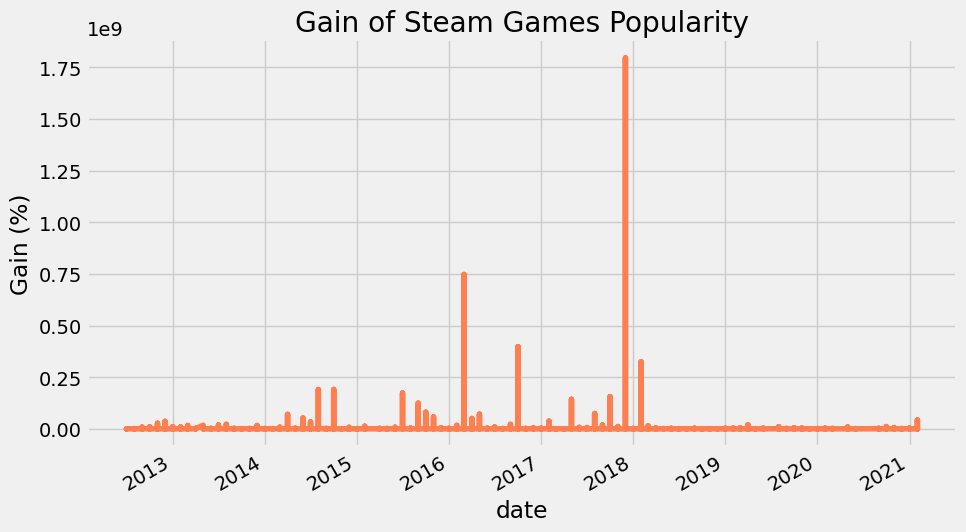

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

df['gain'].plot(ax=ax, color='coral', label='Gain')
ax.set_ylabel('Gain (%)')
ax.set_title('Gain of Steam Games Popularity')

From this visualization we can see that the plot is heavily distorted due to some extreme outliers.

In [ ]:
# Identify outliers in the gain column
mean_gain = df['gain'].mean()
std_gain = df['gain'].std()
threshold = 3

# Get outliers and drop them from the dataframe
outliers = df[(df['gain'] - mean_gain).abs() / std_gain > threshold]
df.drop(outliers.index, inplace=True)

Text(0.5, 1.0, 'Gain of Steam Games Popularity')

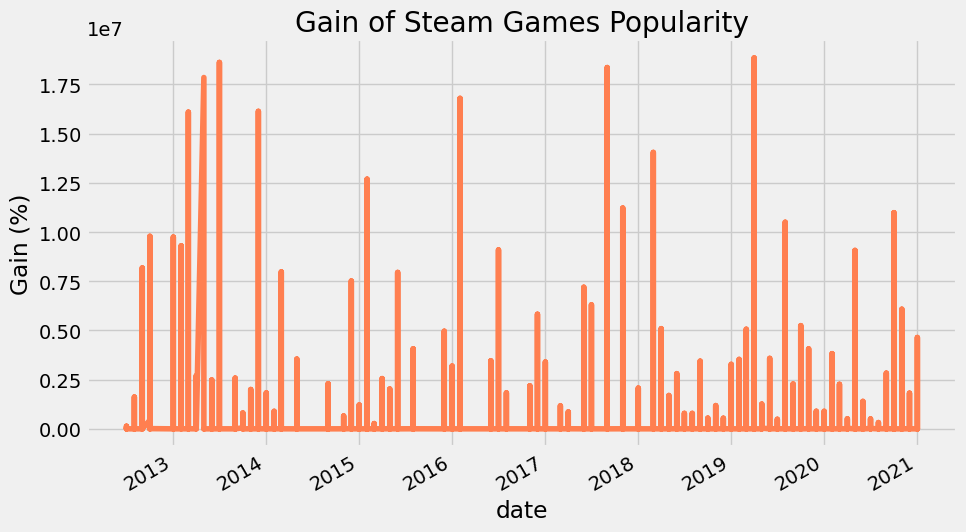

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

df['gain'].plot(ax=ax, color='coral', label='Gain')
ax.set_ylabel('Gain (%)')
ax.set_title('Gain of Steam Games Popularity')

Now that we've removed the extreme outliers we can see we have a more reasonable visualization. Possibly still some less severe outliers left that we could decide to remove in the future.

In [ ]:
# Identify outliers in the avg column
mean_gain = df['avg'].mean()
std_gain = df['avg'].std()
threshold = 3

# Get number of outliers
outliers = df[(df['avg'] - mean_gain).abs() / std_gain > threshold]
print(len(outliers))

223


It seems we have a high number of outliers in the avg column, let's visualize it.

### Avg Preprocessing
- Identify outliers using visualizations and analytics
- Cap outliers

Text(0.5, 1.0, 'Average Players of Steam Games')

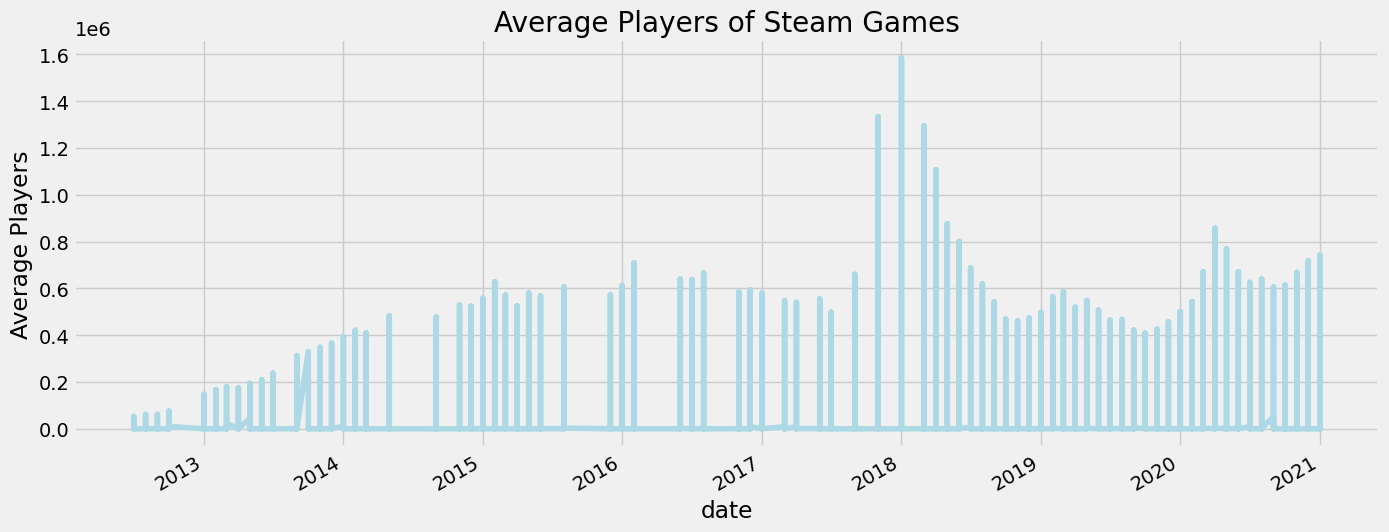

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

df['avg'].plot(ax=ax, color='lightblue', label='Average Players')
ax.set_ylabel('Average Players')
ax.set_title('Average Players of Steam Games')
#Average players of steam games graph w/o outliers

We can see that we have a few outliers in the average players column. However, removing them would leave a significant gap in our dataset. We will instead cap the outliers in order to preserve the relationships.

In [ ]:
# Set outlier threshold and get z-scores
threshold = 30
z_scores = (df['avg'] - mean_gain) / std_gain

# Replace outliers with the threshold value (capped)
df['avg'] = np.where(z_scores > threshold, mean_gain + threshold * std_gain,
                            np.where(z_scores < -threshold, mean_gain - threshold * std_gain, df['avg']))

### Categorical Preprocessing
- Find unique games to identify which encoding method will work best
- Apply appropriate encoding method

In [ ]:
df['gamename'].unique().size #calculates and returns the number of unique game names present in the DataFrame

1260

In [ ]:
encoder = ce.BinaryEncoder(cols=['gamename']) #The encoder will encode the categories

df_encoded = encoder.fit_transform(df['gamename']) #transforming the categorical values into binary-encoded numerical values

df = pd.concat([df.drop('gamename', axis=1), df_encoded], axis=1) #drops the column along the specified axis, then concatenates
df
#gamename column replaced with its binary-encoded representation.

,year,month,avg,gain,peak,avg_peak_perc,gamename_0,gamename_1,gamename_2,gamename_3,gamename_4,gamename_5,gamename_6,gamename_7,gamename_8,gamename_9,gamename_10
date,,,,,,,,,,,,,,,,,
2012-07-01,2012,7,33.76,74743.971252,70,48.2286%,0,0,0,0,0,0,0,0,0,0,1
2012-07-01,2012,7,32.26,-4.443128,231,13.9654%,0,0,0,0,0,0,0,0,0,1,0
2012-07-01,2012,7,12228.47,37805.982641,21811,56.0656%,0,0,0,0,0,0,0,0,0,1,1
2012-07-01,2012,7,19.34,-99.841844,47,41.1489%,0,0,0,0,0,0,0,0,1,0,0
2012-07-01,2012,7,1143.13,5810.703206,2910,39.2828%,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-01,2021,1,925.95,6407.027407,1565,59.1661%,1,0,0,0,1,1,1,1,1,0,1
2021-01-01,2021,1,437.07,-52.797667,1025,42.641%,0,1,1,0,1,1,1,1,1,0,1
2021-01-01,2021,1,1428.79,226.901869,2555,55.9213%,0,0,0,0,0,1,1,1,1,1,0


### Numerical Preprocessing
- Format `avg_peak_perc` by removing '%' and changing dtype
- Scale desired numerical features

In [ ]:
df['avg_peak_perc'] = df['avg_peak_perc'].str.rstrip('%').astype(float) / 100

df

,year,month,avg,gain,peak,avg_peak_perc,gamename_0,gamename_1,gamename_2,gamename_3,gamename_4,gamename_5,gamename_6,gamename_7,gamename_8,gamename_9,gamename_10
date,,,,,,,,,,,,,,,,,
2012-07-01,2012,7,33.76,74743.971252,70,0.482286,0,0,0,0,0,0,0,0,0,0,1
2012-07-01,2012,7,32.26,-4.443128,231,0.139654,0,0,0,0,0,0,0,0,0,1,0
2012-07-01,2012,7,12228.47,37805.982641,21811,0.560656,0,0,0,0,0,0,0,0,0,1,1
2012-07-01,2012,7,19.34,-99.841844,47,0.411489,0,0,0,0,0,0,0,0,1,0,0
2012-07-01,2012,7,1143.13,5810.703206,2910,0.392828,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-01,2021,1,925.95,6407.027407,1565,0.591661,1,0,0,0,1,1,1,1,1,0,1
2021-01-01,2021,1,437.07,-52.797667,1025,0.426410,0,1,1,0,1,1,1,1,1,0,1
2021-01-01,2021,1,1428.79,226.901869,2555,0.559213,0,0,0,0,0,1,1,1,1,1,0


In [ ]:
# Lag feature for 'avg'
df['avg_lag_1'] = df['avg'].shift(1)
df['avg_lag_2'] = df['avg'].shift(2)

# Lag feature for 'gain'
df['gain_lag_1'] = df['gain'].shift(1)
df['gain_lag_2'] = df['gain'].shift(2)
# Add more lag features as needed

# Lag feature for 'peak'
df['peak_lag_1'] = df['peak'].shift(1)
df['peak_lag_2'] = df['peak'].shift(2)
# Add more lag features as needed

# Lag feature for 'avg_peak_perc'
df['avg_peak_perc_lag_1'] = df['avg_peak_perc'].shift(1)
df['avg_peak_perc_lag_2'] = df['avg_peak_perc'].shift(2)

# Create the imputer object
imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Select lag columns to impute
columns_to_impute = ['avg_lag_1', 'avg_lag_2', 'gain_lag_1', 'gain_lag_2',
                     'peak_lag_1', 'peak_lag_2', 'avg_peak_perc_lag_1', 'avg_peak_perc_lag_2']

# Apply imputer on selected columns
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

In [ ]:
# Select rows to scale
scaled_rows = ['gain', 'avg', 'peak', 'avg_peak_perc','avg_lag_1', 'avg_lag_2',
               'gain_lag_1', 'gain_lag_2', 'peak_lag_1', 'peak_lag_2',
               'avg_peak_perc_lag_1', 'avg_peak_perc_lag_2']

# Apply KNN imputation to handle NaN values
imputer = KNNImputer(n_neighbors=5)
df[scaled_rows] = imputer.fit_transform(df[scaled_rows])

# Define Scaler object
scaler = StandardScaler()

# Transform desired rows with the StandardScaler object
df[scaled_rows] = scaler.fit_transform(df[scaled_rows])

df.head()

,year,month,avg,gain,peak,avg_peak_perc,gamename_0,gamename_1,gamename_2,gamename_3,...,gamename_9,gamename_10,avg_lag_1,avg_lag_2,gain_lag_1,gain_lag_2,peak_lag_1,peak_lag_2,avg_peak_perc_lag_1,avg_peak_perc_lag_2
date,,,,,,,,,,,,,,,,,,,,,
2012-07-01,2012,7,-0.112332,0.216655,-0.112029,0.417657,0,0,0,0,...,0,1,-1.549886e-18,0.000002,3.768551e-18,7.936137e-07,-6.600378e-18,0.000002,0.002313,0.005093
2012-07-01,2012,7,-0.112394,-0.052410,-0.108713,-2.169088,0,0,0,0,...,1,0,-1.123337e-01,-0.113728,2.166546e-01,-5.275468e-02,-1.120309e-01,-0.113464,0.418633,-3.195697
2012-07-01,2012,7,0.391503,0.083693,0.335709,1.009322,0,0,0,0,...,1,1,-1.123956e-01,-0.112334,-5.241071e-02,2.166546e-01,-1.087152e-01,-0.112031,-2.162999,0.419229
2012-07-01,2012,7,-0.112928,-0.052753,-0.112503,-0.116834,0,0,0,0,...,0,0,3.915010e-01,-0.112396,8.369217e-02,-5.241071e-02,3.357076e-01,-0.108715,1.009128,-2.148934
2012-07-01,2012,7,-0.066497,-0.031478,-0.053542,-0.257718,0,0,0,0,...,0,1,-1.129294e-01,0.391501,-5.275411e-02,8.369217e-02,-1.125045e-01,0.335708,-0.114801,1.006643


In [41]:
import optuna
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def objective(trial):
    # Define hyperparameters for the RandomForestRegressor
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0)
    }

    # Define the RandomForestRegressor model
    model = RandomForestRegressor(**params)

    # TimeSeriesSplit setup
    n_splits = 3
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []

    for train_index, test_index in tscv.split(df):
        train = df.iloc[train_index]
        test = df.iloc[test_index]

        # Split data into X and y
        X_train, y_train = train.drop('avg', axis=1), train['avg']
        X_test, y_test = test.drop('avg', axis=1), test['avg']

        # Train model
        model.fit(X_train, y_train)
        # Evaluate the model
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        rmses.append(rmse)

    # Calculate average RMSE across all folds
    return np.mean(rmses)


# Create optuna study with Hyperband pruner and TPE sampler
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.HyperbandPruner(),
    sampler=optuna.samplers.TPESampler()
)

# Optimize the study
study.optimize(objective, n_trials=100)

# Print out best parameters
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-04-28 01:53:19,295] A new study created in memory with name: no-name-8ecba09a-dd99-4227-b69d-6e6c94771f34
[I 2024-04-28 01:56:02,549] Trial 0 finished with value: 0.23569093487561954 and parameters: {'n_estimators': 223, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 0.6579319236755569}. Best is trial 0 with value: 0.23569093487561954.
[I 2024-04-28 01:57:02,195] Trial 1 finished with value: 0.30232609233462876 and parameters: {'n_estimators': 209, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 0.41882542239487697}. Best is trial 0 with value: 0.23569093487561954.
[I 2024-04-28 01:57:17,907] Trial 2 finished with value: 0.6542318681999079 and parameters: {'n_estimators': 266, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 0.10603193253422388}. Best is trial 0 with value: 0.23569093487561954.
[I 2024-04-28 01:57:55,929] Trial 3 finished with value: 0.24570806759604302 and parameters

Best trial:
 Value: 0.1603232399217315
 Params: 
    n_estimators: 185
    max_depth: 10
    min_samples_split: 2
    min_samples_leaf: 1
    max_features: 0.9737220503924302


In [43]:
# Params from optuna study
xgb_params = {
    'n_estimators': 300,
    'max_depth': 3,
    'learning_rate': 0.2133245553107171,
    'subsample': 0.6875647355747811,
    'colsample_bytree': 0.9885033916549564,
    'min_child_weight': 1

}

# Here you fill in your results
rf_params = {
    'n_estimators': 185,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 0.9737220503924302
}

# Define other params for models
...


# Put the models into the estimators base
estimators = [
    ('xgb', xgb.XGBRegressor(**xgb_params)),
    ('rf', RandomForestRegressor(**rf_params))
]

# Meta estimator decides how to combine the base estimators
meta_estimator = LinearRegression(...)

# Define the stacking regressor
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=meta_estimator)

# Define the features and target variable
features = df.drop('avg', axis=1)
target = df['avg']

# Define the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

# List to store the performance metrics for each fold
scores = []

# Loop over each train-test split
for train_idx, test_idx in tscv.split(features):
    X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]

    # Fit the model on the training data
    stacking_regressor.fit(X_train, y_train)

    # Predict on the test data
    y_pred = stacking_regressor.predict(X_test)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(rmse)
    print(f"RMSE for the current split: {rmse}")

# Calculate average RMSE over all splits
average_rmse = np.mean(scores)
print(f"Average RMSE over all splits: {average_rmse}")

TypeError: LinearRegression.__init__() takes 1 positional argument but 2 were given